### This script is used to check evolution of the Paluch diagram (Figure 15) in BB2017

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os 
from scipy import interpolate

In [2]:
from matplotlib import animation
#import seaborn as sbn         # not available in the environment yet.

In [3]:
import ipywidgets as widgets

In [4]:
%matplotlib inline

In [5]:
# specify the data path:
datadir = '/data/xchen/BB2017'

folder1 = 'OUT_2D'
folder2 = 'OUT_3D'    # 
folder3 = 'OUT_STAT'  # time-varying, horizontally-averaged profiles of domain-mean quantities

filename_stat = 'S6_CTL_512sqx128_250m_testf.nc'
file_prefix = 'S6_CTL_512sqx128_250m_testf'
#filename_3D = 'S6_CTL_MSE_512sqx128_250m_testf_0128_CONCAT.nc'


# establish a dictionary for the filename:
filenames=dict()
filenames['cntrl']=file_prefix + '.nc'
filenames['noPCP'] = file_prefix + '_noPCP.nc'
filenames['RADhomo'] = file_prefix + '_RADhomo.nc'
filenames['RADFLXhomo']=file_prefix + '_RADFLXhomo.nc'
filenames['RFhomoNoPCP']=file_prefix + '_RADFLXhomo_noPCP.nc'
filenames['WTG'] = file_prefix + '_WTG.nc'


In [6]:
# manually select a simulation case to make the evolution movie:
testcase_label='noPCP'
filename_stat = filenames[testcase_label]
print(filename_stat)
absfn = os.path.join(datadir, folder3, filename_stat)
ds_stat = xr.open_dataset(absfn)


S6_CTL_512sqx128_250m_testf_noPCP.nc


In [7]:
# domain mean thermodynamci:
# compute the virtual liquid static energy:
# note that Lv and Cp are set to the same value as used in the SAM model.
Lv = 2.5104*10**6
mu = 0.93
Cp = 1003.5
ds_stat['Svl'] = ds_stat.MSE - mu*Lv*(ds_stat.QT/1000)/Cp


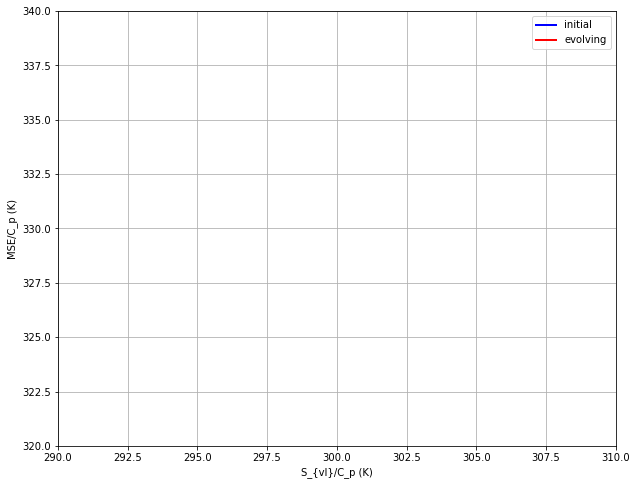

In [8]:
# domain mean thermodynamics:
# make the evolution in an animation:
# source of reference: https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

from IPython.display import HTML

# first set up the figure, the axis, and the plot element
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim((290,310))
ax.set_ylim((320,340))
line1,  = ax.plot([],[], lw =2,color='b')
line2, = ax.plot([],[], lw=2, color='r')
line3, = ax.plot([],[],linestyle='--', color='b')
line4, = ax.plot([],[],linestyle='--', color='r')
ax.set_xlabel('S_{vl}/C_p (K)')
ax.set_ylabel('MSE/C_p (K)')
titlestr = ax.set_title('')
ax.legend(['initial','evolving'])
ax.grid(True)



In [9]:
def init():
    line1.set_data([],[])
    line2.set_data([],[])
    line3.set_data([],[])
    line4.set_data([],[])
    return (line1, line2,line3, line4,  
             )

# example function for animation:
# def animate(i):
#     x = np.linspace(0,2,1000)
#     y = np.sin(2*np.pi * (x-0.01*i))
#     line.set_data(x,y)
#     return (line,)


# 
def animate_Paluch(i):
    #fig, ax = plt.subplots(1,1, figsize=(10,10))
    ds_sub = ds_stat.where(ds_stat.z<ds_stat.ZINV[0]*1000, drop=True)
    # initial:
    x0 = ds_sub.Svl[0,:]
    y0 = ds_sub.MSE[0, :]
    line1.set_data(x0, y0)
   

   # work around #2: create a finer vertical levels from 0 to ZINV. 
    z_fine= np.linspace(ds_stat.z[0], ds_stat.ZINV[i]*1000, 300)
    f_MSE = interpolate.interp1d(ds_stat.z, ds_stat.MSE[i,:])
    f_Svl = interpolate.interp1d(ds_stat.z, ds_stat.Svl[i,:])
    yi = f_MSE(z_fine)
    xi = f_Svl(z_fine)
    
    line2.set_data(xi, yi)
    
    line3.set_data([x0[0], x0[-1]], [y0[0], y0[-1]])
    line4.set_data([xi[0], xi[-1]], [yi[0], yi[-1]])
    
    dt = (ds_sub.time[i]-ds_sub.time[0])*24.0
    titlestr.set_text('Time {1:d} = {0:.2f} th hour '.format(dt.values, i))
    
    #ax.plot(ds_sub2.Svl[i,:], ds_sub2.MSE[i, :],color='r')
    #ax.plot([ds_sub2.Svl[i,0], ds_sub2.Svl[i,-1]], [ds_sub2.MSE[i,0], ds_sub2.MSE[i,-1]],
#            linestyle='--', color='r')
     
#     ax.set_title('time:' + "{:.2f}".format(dt.values) + 'th hr')
#     ax.grid(grid)
#     ax.set_ylim(320, 340)
#     ax.set_xlim(290, 310)
   
    return(line1, line2, line3, line4,)
 




In [11]:
# frame = number of snapshots, interval = milliseconds delayed between the two frames (default=200).
anim =animation.FuncAnimation(fig, animate_Paluch, init_func=init, frames=range(len(ds_stat.time)), interval=100, blit=True)


In [ ]:
# this will take a while...
HTML(anim.to_html5_video())

In [ ]:
f = r"/home/xchen/jupyter_notebook/LES/BB2017_analysis/output/control_MSE_Svl_Evolution_" + testcase_label +".mp4" 
writervideo = animation.FFMpegWriter(fps=5) 
anim.save(f, writer=writervideo)

In [63]:
# plot the curve at 36 hours from different sensitivity runs:
# 1. loop through the dictionary
#   - read data;
#.  - find the profiles at 36th hour 
#   - save the results for different cases into a dictionary
# 2. make plots

hr=36
ds=dict()
MSE_tc=dict()
Svl_tc=dict()
cnt = 0
for k in filenames:
   
    print(k)
    # read data:
    absfn= os.path.join(datadir, folder3, filenames[k])
    ds_tmp = xr.open_dataset(absfn)
    
    # compute Svl from MSE
    Lv = 2.5104*10**6
    mu = 0.93
    Cp = 1003.5
    ds_tmp['Svl'] = ds_tmp.MSE - mu*Lv*(ds_tmp.QT/1000)/Cp    
    
    
    if cnt==0:
        dz=ds_tmp.z-ds_tmp.ZINV[0]*1000
        zid= np.where(abs(dz)==np.min(abs(dz)))
        ds_sub = ds_tmp.where(ds_tmp.z<=ds_tmp.z[zid].values, drop=True)
        MSE_t0 = ds_sub.MSE[0,:]
        Svl_t0 = ds_sub.Svl[0,:]
    
    
    dt = ds_tmp.time - (ds_tmp.time[0]+hr/24.0)
    it = np.where(abs(dt)==np.min(abs(dt)))[0]
#     if it>=len(ds_tmp.time):
#         it=-1
        
    
    # get the profiles of interest at 36th hour:
    z_fine= np.linspace(ds_tmp.z[0], ds_tmp.ZINV[it]*1000, 300)
    f_MSE = interpolate.interp1d(ds_tmp.z, ds_tmp.MSE[it,:])
    f_Svl = interpolate.interp1d(ds_tmp.z, ds_tmp.Svl[it,:])
    MSE_tc[k] = f_MSE(z_fine)
    Svl_tc[k] = f_Svl(z_fine)
    
    ds_tmp.close()
    
    cnt += 1
    


cntrl
noPCP
RADhomo
RADFLXhomo
RFhomoNoPCP
WTG


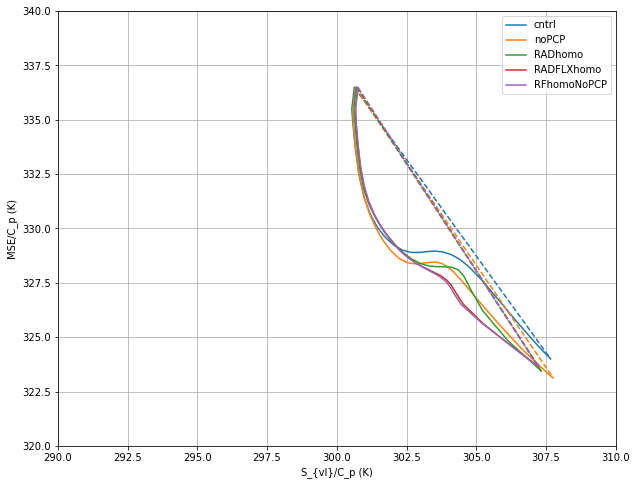

In [98]:
# make plot here to summarize the changes in the curve with the different physical processes activated (or deactivated)
fig03, axes03=plt.subplots(1,1, figsize=(10,8))
ii=0
lgdstr=[None]*6
lncolor=[None]*6
for k in MSE_tc:    
    if ii<=4:
        ln,=axes03.plot(Svl_tc[k][0], MSE_tc[k][0])
        lncolor[ii]=ln.get_color()
        axes03.plot([Svl_tc[k][0][0], Svl_tc[k][0][-1]],[MSE_tc[k][0][0], MSE_tc[k][0][-1]],
                              linestyle='--', color=lncolor[ii], label='_nolegend_')
        axes03.set_xlabel('S_{vl}/C_p (K)')
        axes03.set_ylabel('MSE/C_p (K)')
        lgdstr[ii]=k
        axes03.legend(lgdstr)
        axes03.grid(True)
        axes03.set_ylim([320, 340])
        axes03.set_xlim([290, 310])
    
    ii += 1


Here, I plotted the thermodynmaic profiles at 36th hour in each sensitivity simulations shared by Peter. 
Eliminating different physical processes changes the curvature of the line, which is associated with the thermodynamic  properties higher up closer to the inversion height. 

In the control case, where all the physicall processes are activated (rain, interactive radiative and surface flux feedback), the two conserved variables (or moisture and temperature) in this diagram is more linear related, and their relationship behaves closer to the mixing line. 

When the precipitation is shut down (noPCP, orange), the slope of the mixing line is steepened (absolute value of the slope is increased, large change of moisture per unit Tvl), area of concavity increases a bit from the control.

If the radiative heating rate is horizontally homogenized (green) but still rain, the increase in the slope of the mixing line is larger than in the noPCP case.  The difference of concavity area from the control case remains similar as in the noPCP case. 

Now when the response of surface fluxes to aggregation is also homogenized horizontally on top of the RADhomo case, the thermodynamic properties near the cloud top change further and the concave area further increases.

Further shutting off precipitation from the RADFLXhomo does not change the overall behavior of the MSE-Svl curve or the mixing line significantly.

It seems to me that the inhomogenized surface flux response quite significant contribution to the curvature change in the MSE-Svl diagram..


In [69]:
f = r"/home/xchen/jupyter_notebook/LES/BB2017_analysis/output/MSE_Svl_different_simulations_36th.jpg"
fig03.savefig(f)

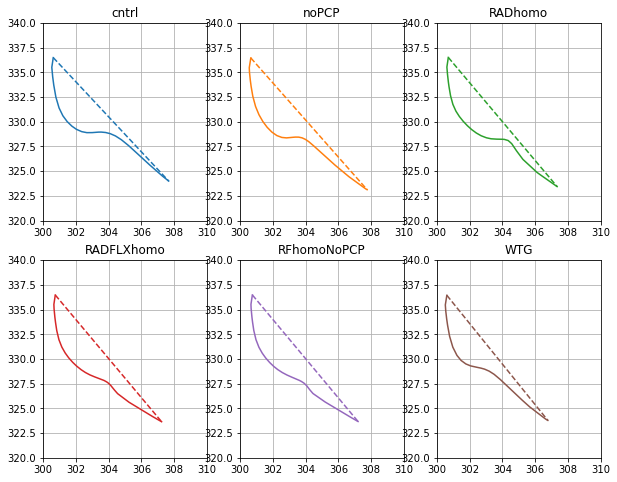

In [96]:
fig03, axes03=plt.subplots(2,3, figsize=(10,8))
axes_col = axes03.reshape(-1)
ii=0
lgdstr=[None]*6

for k in MSE_tc:    
    ln,=axes_col[ii].plot(Svl_tc[k][0], MSE_tc[k][0],color=lncolor[ii])
    #lncolor=ln.get_color()
    axes_col[ii].plot([Svl_tc[k][0][0], Svl_tc[k][0][-1]],[MSE_tc[k][0][0], MSE_tc[k][0][-1]],
                          linestyle='--', color=lncolor[ii], label='_nolegend_')
    lgdstr[ii]=k
    axes_col[ii].set_title(k)
    axes_col[ii].grid(True)
    #axes_col[ii].legend(lgdstr)
    
    axes_col[ii].set_ylim([320, 340])
    axes_col[ii].set_xlim([300, 310])
    ii += 1

WTG approximation seems like a reasonable representation of the control case. 


In [70]:
f = r"/home/xchen/jupyter_notebook/LES/BB2017_analysis/output/MSE_Svl_different_simulations_36th_separated.jpg"
fig03.savefig(f)

In [120]:
# check how correlated it is between the two metrics that is used to identify aggregation


In [1]:
# interactively check where the inversion height is.
@widgets.interact(it=(0, len(ds_stat.ZINV),6))
def check_inv_loc(it=200):
    # check to see if the inversion height is at the maximum temperature gradient.
    zmask=ds_stat.z<4000
    gradT=np.gradient(ds_stat.THETAL[it,zmask])
    gradQ=np.gradient(ds_stat.QV[it,zmask])
    zinv_g=np.where(gradT==np.max(gradT))
    plt.plot(gradT, ds_stat.z[zmask])
    plt.plot(gradQ, ds_stat.z[zmask])
    plt.plot([-1,5],[ds_stat.ZINV[it]*1000,ds_stat.ZINV[it]*1000],linestyle='--')
    plt.legend(['gradT','gradQ','diagnosed ZINV'])
    plt.show()

NameError: name 'widgets' is not defined

In [74]:
# another thing to check is that: is the ZINV correspond to the real inversion height produced from the model?
it=200
@widgets.interact(it=(0, len(ds_stat.ZINV),6))
def check_domain_mean_parms(it=200):
    fig01, axes = plt.subplots(2,2,figsize=(10,10))
    # thetaL: liquid water potential temperature
    axes[0,0].plot(ds_stat.THETAL[it,:], ds_stat.z)
    axes[0,0].plot([290, 320],[ds_stat.ZINV[it]*1000, ds_stat.ZINV[it]*1000], 
                  linestyle='--')
    axes[0,0].set_ylim(0, ds_stat.ZINV[it]*1000*1.5)
    axes[0,0].set_xlim(290, 320)
    axes[0,0].set_title(ds_stat.THETAL.long_name)
    axes[0,0].set_ylabel(ds_stat.z.long_name)
    axes[0,0].set_xlabel('theta_l (K)')
    axes[0,0].grid(True)


    # qv: water vapor mixing ratio
    axes[0,1].plot(ds_stat.QV[it,:], ds_stat.z)
    axes[0,1].plot([0, 16],[ds_stat.ZINV[it]*1000, ds_stat.ZINV[it]*1000], 
                  linestyle='--')
    axes[0,1].set_ylim(0, ds_stat.ZINV[it]*1000*1.5)
    axes[0,1].set_xlim(0, 16)
    axes[0,1].set_title(ds_stat.QV.long_name)
    #axes[0,0].set_ylabel(ds_stat.z.long_name)
    axes[0,1].set_xlabel('q_v (g/kg)')
    axes[0,1].grid(True)
    
    
    # U: zonal wind
    axes[1,0].plot(ds_stat.U[it,:], ds_stat.z)
    axes[1,0].plot(ds_stat.UOBS[it,:], ds_stat.z,linestyle='--',color='g')
    axes[1,0].plot([-15, 15],[ds_stat.ZINV[it]*1000, ds_stat.ZINV[it]*1000], 
                  linestyle='--')
    axes[1,0].set_ylim(0, ds_stat.ZINV[it]*1000*1.5)
    axes[1,0].set_xlim(-15, 15)
    axes[1,0].set_title(ds_stat.U.long_name)
    #axes[0,0].set_ylabel(ds_stat.z.long_name)
    axes[1,0].set_xlabel('U (m/s)')
    axes[1,0].grid(True)
    axes[1,0].legend(['U','UOBS'])
    
    
    # V: zonal wind
    axes[1,1].plot(ds_stat.V[it,:], ds_stat.z)
    axes[1,1].plot(ds_stat.VOBS[it,:], ds_stat.z,linestyle='--',color='g')
    axes[1,1].plot([-15, 15],[ds_stat.ZINV[it]*1000, ds_stat.ZINV[it]*1000], 
                  linestyle='--')
    axes[1,1].set_ylim(0, ds_stat.ZINV[it]*1000*1.5)
    axes[1,1].set_xlim(-15, 15)
    axes[1,1].set_title(ds_stat.V.long_name)
    #axes[0,0].set_ylabel(ds_stat.z.long_name)
    axes[1,1].set_xlabel('V (m/s)')
    axes[1,1].grid(True)
    axes[1,1].legend(['V','VOBS'])
    
    plt.show()


# wind field:


interactive(children=(IntSlider(value=200, description='it', max=216, step=6), Output()), _dom_classes=('widge…

In [58]:
ds_stat

<xarray.Dataset>
Dimensions:     (time: 432, z: 128)
Coordinates:
  * z           (z) float32 40.0 120.0 200.0 ... 1.812e+04 1.884e+04 1.961e+04
  * time        (time) float32 196.0 196.0 196.0 196.0 ... 199.0 199.0 199.0
Data variables: (12/559)
    p           (z) float32 1.009e+03 1e+03 991.2 982.2 ... 76.38 67.62 59.59
    SST         (time) float32 298.8 298.8 298.8 298.8 ... 298.8 298.8 298.8
    Ps          (time) float32 1.014e+03 1.014e+03 ... 1.014e+03 1.014e+03
    CLDSHD      (time) float32 0.0 0.0 0.0 0.0 ... 0.09236 0.09078 0.08695
    AREAPREC    (time) float32 0.0 0.0 0.0 0.0 ... 0.0306 0.02953 0.02936
    CLD245      (time) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...          ...
    QVENV       (time, z) float32 15.61 15.28 15.13 ... 0.002307 0.002105
    QCENV       (time, z) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    QTOENV      (time, z) float32 15.61 15.28 15.13 ... 0.002307 0.002105
    QRENV       (time, z) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    NRENV       (time, z) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Svl         (time, z) float32 300.8 300.7 300.7 300.7 ... 379.5 389.5 399.4
Attributes:
    SAM version:  
    caseid:       512sqx128_250m_testf

In [ ]:
@widgets.interact(i=(0,len(ds_stat.ZINV),10))
def test(i=10):
    dz=ds_stat.z-ds_stat.ZINV[i]*1000
    test=ds_stat.where(abs(ds_stat.z-ds_stat.ZINV[i]*1000)==np.min(abs(dz)), drop=True)
    print(ds_stat.ZINV[i].values*1000)
    print(test.z[-1].values)
    plt.plot(ds_stat.time, ds_stat.ZINV*1000)
    #plt.plot(ds_stat.time[1]*np.ones(len(ds_stat.z)), ds_stat.z,marker='.')
    plt.plot(ds_stat.time[i],test.z[-1],marker='*')
    plt.show()



In [40]:
# Test work around # 1:
z_trunc=[None]*len(ds_stat.ZINV)
for i in range(len(ds_stat.ZINV)):
    dz=ds_stat.z-ds_stat.ZINV[i]*1000
    test= np.where(abs(dz)==np.min(abs(dz)))   
    z_trunc[i]=ds_stat.z[test].values
#     print(ds_stat.ZINV[i].values*1000)
#     print(test.z[-1].values)


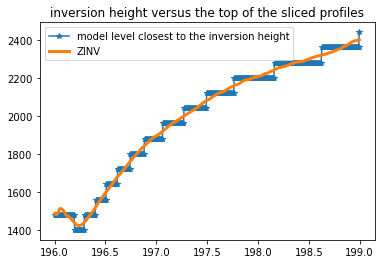

In [45]:
#plt.plot(ds_stat.time[1]*np.ones(len(ds_stat.z)), ds_stat.z,marker='.')
plt.plot(ds_stat.time,z_trunc,marker='*')
plt.plot(ds_stat.time, ds_stat.ZINV*1000,linewidth=3)
plt.title('inversion height versus the top of the sliced profiles')
plt.legend(['model level closest to the inversion height','ZINV'])
plt.show()
plt.savefig()

work around #1 will still produce jumpiness because the discrete nature of the vertical levels in the LES model
The solution is to interpolate the LES vertical profiles of MSE and $S_{vl}$ to the exact inversion height which is a smooth curve. 

(0.0, 3000.0)

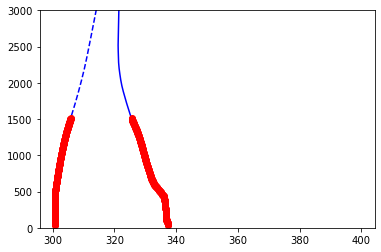

In [99]:
# Test work around #2:
i = 10
# work around #2: create a finer vertical levels from 0 to ZINV. 
z_fine= np.linspace(ds_stat.z[0], ds_stat.ZINV[i]*1000, 300)
f_MSE = interpolate.interp1d(ds_stat.z, ds_stat.MSE[i,:])
f_Svl = interpolate.interp1d(ds_stat.z, ds_stat.Svl[i,:])
MSE_subfine = f_MSE(z_fine)
Svl_subfine = f_Svl(z_fine)

# plot out interpolation result to confirm:
plt.plot(ds_stat.MSE[i,:], ds_stat.z, color='b')
plt.plot(MSE_subfine, z_fine, color='r', linestyle=None, marker='o')
plt.ylim(0,3000)

plt.plot(ds_stat.Svl[i,:], ds_stat.z, color='b',linestyle='--')
plt.plot(Svl_subfine, z_fine, color='r', linestyle='--', marker='o')
plt.ylim(0,3000)


In [107]:
def plot(i=10, grid=True):
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    
    ds_sub = ds_stat.where(ds_stat.z<=ds_stat.ZINV[0]*1000, drop=True)
    # initial:
    ax.plot(ds_sub.Svl[0,:], ds_sub.MSE[0, :],color='b')
    ax.plot([ds_sub.Svl[0,0], ds_sub.Svl[0,-1]], [ds_sub.MSE[0,0], ds_sub.MSE[0,-1]],
           linestyle='--', color='b')
    
    # work around #2: create a finer vertical levels from 0 to ZINV. 
    z_fine= np.linspace(ds_stat.z[0], ds_stat.ZINV[i]*1000, 300)
    f_MSE = interpolate.interp1d(ds_stat.z, ds_stat.MSE[i,:])
    f_Svl = interpolate.interp1d(ds_stat.z, ds_stat.Svl[i,:])
    MSE_subfine = f_MSE(z_fine)
    Svl_subfine = f_Svl(z_fine)

    
    ax.plot(Svl_subfine, MSE_subfine,color='r')
    ax.plot([Svl_subfine[0], Svl_subfine[-1]], [MSE_subfine[0], MSE_subfine[-1]],
           linestyle='--', color='r')
    dt = (ds_sub.time[i]-ds_sub.time[0])*24.0
    ax.set_title('time:' + "{:.2f}".format(dt.values) + 'th hr')
    ax.grid(grid)
    ax.set_ylim(320, 340)
    ax.set_xlim(290, 310)
    plt.show()
 


interactive(children=(IntSlider(value=10, description='i', max=216, step=6), Checkbox(value=True, description=…

<function __main__.plot(i=10, grid=True)>

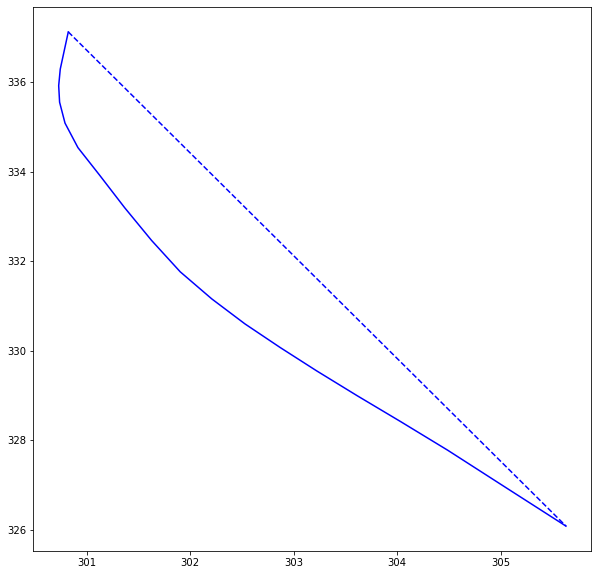

In [108]:
widgets.interact(plot, i=(0,len(ds_stat.ZINV),6))


In [ ]:
# very first trial
# for i in range(len(ds_stat.ZINV)):
#     ds_sub = ds_stat.where(ds_stat.z<ds_stat.ZINV[0]*1000, drop=True)
#     fig,ax=plt.subplots(1,1,)
#     ax.plot(ds_sub.DSE[0,:], ds_sub.MSE[0, :],color='b')
#     ax.plot([ds_sub.DSE[0,0], ds_sub.DSE[0,-1]], [ds_sub.MSE[0,0], ds_sub.MSE[0,-1]],
#            linestyle='--', color='b')

#     ds_sub2 = ds_stat.where(ds_stat.z<ds_stat.ZINV[i]*1000, drop=True)
#     ax.plot(ds_sub2.DSE[i,:], ds_sub2.MSE[i, :],color='r')
#     ax.plot([ds_sub2.DSE[i,0], ds_sub2.DSE[i,-1]], [ds_sub2.MSE[i,0], ds_sub2.MSE[i,-1]],
#            linestyle='--', color='r')
    